# Trying to estimate the transcriptome saturation of our scRNA-seq data.

#### Alex Ferrena, Tammela Lab, MSKCC

"Transcriptome saturation" (aka, "coverage") is a sensitivty metric that attempts to estimate the breadth of capture of unique transcripts by RNA-seq. It is particularly of interest when considering rare/relatively lowly expressed transcripts; experimental protocols may bias against capture of these in favor of very highly expressed transcripts, which may be of lesser interest. For example, reverse transcription or PCR amplification of rare transcripts may be disfavored due to their relatively low level in the reaction compared to highly abundant RNA species.

[Zieganhan et al 2017](https://www.sciencedirect.com/science/article/pii/S1097276517300497) and [Wu et al 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4022966/) both estimate transcriptome saturation and inspired this analysis. However, both papers use a strategy at the raw fastq level. First, they normalize across "conditions" (in each case, they are comparing various scRNA-seq library prep/sequencing protocols); they do this by first selecting a baselin of 1 million reads). From there, they systematically downsample further (ie 0-100% of 1 million, ostensibly in discrete intervals); each downsampling is then processed via the same alignment/quantification pipeline. This seems computationally heavy, so with Dr. Jason Chan's guidance I have set out to try to accomplish a similar estimation, but instead downsampling at the gene expression matrix level (post alignment); thus, we can estimate a similar metric but with higher speed and efficiency.

### load in data and setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
vh = pd.read_csv('C:\\Users\\Alexander\\My Documents\\tam\\CV_project/data/GH1110_KW1306-control_dense.csv')

In [3]:
np.random.seed(123)

In [4]:
vh = pd.DataFrame.transpose(vh)

In [5]:
vh = vh.iloc[2:]

## Small scale example, devising strategy

Three different strategies are outlined to try to estimate the transcriptome saturation.
Each involves taking the "rowsum" of genes across all cells to get a total numberof genes detected in the sequencing run. Then, the gene counts are converted to proportions (each gene counts/total gene counts). Finally, a random number from [0-1] (a "downsampling factor") is generated and compared to the gene expression level in one of three ways many times, as described below:

1. after taking the expression proportion, the "cumulative sum" of proportion was calculated. This is the cumulative sum of each gene in some order; the arbitrary default ordering of the genes in the given expression matrix was used. The random number is compared to the cumulative sum: for each input the number of genes with a cumulative sum below the downsampling factor is counted and stored.

2. The proportion of genes is directly compared to each downsampling factor. The number of genes greater than the downsampling factor is counted.

3. The proportion of genes is again directly compared to each downsampling factor. The number of genes less than the downsampling factor is counted.

### cumulative proportion approach

In [6]:
df = vh.iloc[0:20, 0:20]
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
GNAI3,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0
CDC45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
H19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
APOH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NARF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CAV2,3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
KLF6,31,0,0,15,0,9,1,3,0,0,0,0,3,5,9,8,0,1,0,0
SCMH1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,1,0,0
COX5A,15,0,0,4,0,1,0,2,0,0,0,0,6,0,7,6,0,0,0,0
TBX2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
rs = df.sum(axis=1)
rs

GNAI3        6
CDC45        0
H19          0
APOH         0
NARF         0
CAV2         6
KLF6        85
SCMH1        7
COX5A       41
TBX2         0
TBX4         0
NGFR         0
WNT9A        0
FER          2
XPO6         2
TFE3         6
AXIN2        0
BRAT1        1
GNA12        0
SLC22A18     1
dtype: int64

In [8]:
rssparse = rs[rs!=0]
rssparse

GNAI3        6
CAV2         6
KLF6        85
SCMH1        7
COX5A       41
FER          2
XPO6         2
TFE3         6
BRAT1        1
SLC22A18     1
dtype: int64

In [9]:
tot = rssparse.sum(axis=0)
tot

157

In [10]:
rsprop = pd.DataFrame(rssparse/tot, columns=['prop'])

In [11]:
rsprop['cumprop'] = np.cumsum(rsprop)
rsprop

,prop,cumprop
GNAI3,0.038217,0.038217
CAV2,0.038217,0.076433
KLF6,0.541401,0.617834
SCMH1,0.044586,0.662420
COX5A,0.261146,0.923567
FER,0.012739,0.936306
XPO6,0.012739,0.949045
TFE3,0.038217,0.987261
BRAT1,0.006369,0.993631
SLC22A18,0.006369,1.000000


create an array of 100 random numbers in a uniform distribtuion ranging from 0 to 1

In [14]:
lookup = np.random.uniform(low=0.0, high=1.0, size=100)
downsample = pd.DataFrame(lookup, columns=['downsamplefactor'])

'compare' array to our pooled data: cumulative sums of genes ordered in our arbitraty input method are 'counted' if they are less than or equal to the query.
using less than because we're downsampling: assuming we only sequenced #reads * input fraction (lower than reads), we expect fewer genes, but how many fewer? acceptable level? 

In [15]:
ds =[]
for i in lookup:
    ds.append(sum(rsprop['cumprop'] <= i))
    
downsample['genesdetected'] = ds

In [16]:
downsample.head()

,downsamplefactor,genesdetected
0,0.696469,4
1,0.286139,2
2,0.226851,2
3,0.551315,2
4,0.719469,4


In [17]:
dsordered = downsample.sort_values(by='downsamplefactor', ascending=True)
dsordered.tail()

,downsamplefactor,genesdetected
84,0.925132,4
38,0.944160,5
6,0.980764,6
47,0.985560,6
91,0.995358,7


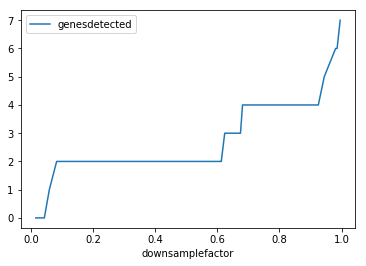

In [18]:
dsordered.plot(x='downsamplefactor', y='genesdetected')

# conclusion
what this does is takes the input gene expression matrix, takes the sum across all cells, converts to proportions/compositional data, then randomly takes some input from 0-1 and compares that to the cumulative sum. But doesn't this just bias the "detection" to genes at the beginning of the arbitrary list that is cumulatively added?








## gene proportion, greater than approach

Compares some random number from 0-1 with the proportional amounts of gene expression data.

Here, I first thought it made sense to use greater than rather than less than. this is because the we are querying some random [0-1] number against the proportions, and so higher proportion genes (corresponding to highly expressed) should have a greater chance of being detected.



Put another way, it doesn't make sense that very low sequencing amounts (# reads * very low input value) should INCREASE sensitvity, which would be the case if we were to use less than, I think.

In [43]:
downsample = pd.DataFrame(lookup, columns=['downsamplefactor'])
ds =[]
for i in lookup:
    ds.append(sum(rsprop['prop'] >= i))
    
downsample['genesdetected'] = ds

In [44]:
downsample.head()

,downsamplefactor,genesdetected
0,0.696469,0
1,0.286139,1
2,0.226851,2
3,0.551315,0
4,0.719469,0


In [45]:
dsordered = downsample.sort_values(by='downsamplefactor', ascending=True)

In [46]:
rsprop

,prop,cumprop
GNAI3,0.05,0.05
CAV2,0.03,0.08
KLF6,0.54,0.62
SCMH1,0.06,0.68
COX5A,0.26,0.94
XPO6,0.02,0.96
TFE3,0.03,0.99
BRAT1,0.01,1.00


In [47]:
dsordered

,downsamplefactor,genesdetected
74,0.016129,7
87,0.043591,4
13,0.059678,3
65,0.083195,2
30,0.092105,2
70,0.095713,2
41,0.115618,2
50,0.120629,2
96,0.151127,2
78,0.153071,2


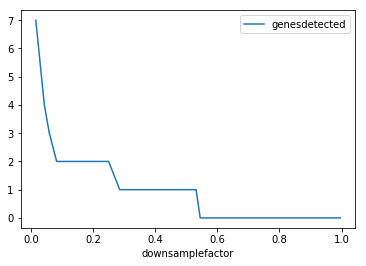

In [48]:
dsordered.plot(x='downsamplefactor', y='genesdetected')

### gene proportion, less than approach

count genes with proportion lower than random number [0-1]

In [19]:
downsample = pd.DataFrame(lookup, columns=['downsamplefactor'])
ds =[]
for i in lookup:
    ds.append(sum(rsprop['prop'] <= i))
    
downsample['genesdetected'] = ds
dsordered = downsample.sort_values(by='downsamplefactor', ascending=True)

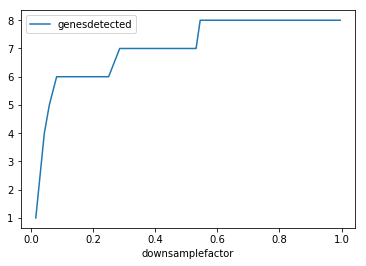

In [20]:
dsordered.plot(x='downsamplefactor', y='genesdetected')

this time, what we ar doing is counting the number of genes that have a proportion less than some random number [0-1]. I think this doesn't really make a lot of sense as we approach 0, since we will be exclusing those genes that have high proportions.

## conclusion


Three strategies were devised to estimate transcriptome saturation. Basically, it involves comparing our observed gene expression with some "downsampling factor".

The first strategy takes some random number [0-1] and counts the number of genes of cumulative proportion below that number; the bias is against genes at the end of the arbitrary input order. I think counting genes above the downsampling factor would have pretty much the same arbitrary bias.

The second method takes some random number [0-1] and counts the number of genes with a proportion above that number. In this case, a low downsampling factor (say, 0) will detect all/more genes, while a high downsampling factor (say, 1) will detect no/fewer genes. Lowly expressed genes (low proportions) will depend on low downsampling factors, while, highly expressed genes (high proportion) are more robust and will show up over a greater range of downsampling factor levels; they will only be exclued with a high enough factor level. Thus, this strategy seems to make the most sense, even if the plot looks different than the paper.

For completeness, a third method was also tried - this involved counting those genes below each given the downsampling factor. This seems to induce a bias against the highly expressed genes (hi proportion); they are being excluded across a large range of downsampling factors, which doesn't seem to make sense.

Perhaps the differences is more arbitrary than I am describing here but I think the 2nd strategy makes the most sense.

## so test in bigger dataset

#### set up rowsum proportion vector as above

In [32]:
vh.head()

,0,1,2,3,4,5,6,7,8,9,...,2385,2386,2387,2388,2389,2390,2391,2392,2393,2394
GNAI3,1,0,0,1,0,1,0,0,0,1,...,0,0,0,1,2,0,0,0,0,0
CDC45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
H19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
APOH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NARF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
rs = vh.sum(axis=1)
rs.head()

GNAI3    1308
CDC45      46
H19         6
APOH       10
NARF      243
dtype: int64

In [38]:
rssparse = rs[rs!=0]

In [40]:
print(len(rs))
print(len(rssparse))

17209
17209


weird. preprocessing qc somehow.

In [41]:
tot = rssparse.sum(axis=0)
tot

24517752

In [42]:
rsprop = pd.DataFrame(rssparse/tot, columns=['prop'])

#### get lookup vector; one million numbers between [0-1]

repeat with 1 mil...

In [43]:
lookup = np.random.uniform(low=0.0, high=1.0, size=100000)
downsample = pd.DataFrame(lookup, columns=['downsamplefactor'])

In [45]:
ds =[]
for i in lookup:
    ds.append(sum(rsprop['prop'] >= i))
    
downsample['genesdetected'] = ds

took about a minute

In [46]:
dsordered = downsample.sort_values(by='downsamplefactor', ascending=True)

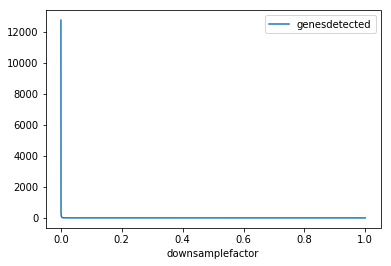

In [47]:
dsordered.plot(x='downsamplefactor', y='genesdetected')

not what i was expecting. try to figure out what's going on

In [48]:
dsordered.head()

,downsamplefactor,genesdetected
76153,9.102816e-07,12767
73612,1.822016e-05,5373
67795,3.861565e-05,2982
2483,6.783831e-05,1793
394,8.188761e-05,1502


In [58]:
rs.value_counts(ascending=False).head()

1    1077
2     555
3     432
4     301
5     242
dtype: int64

In [60]:
rsprop.tail()

,prop
RP23-292G1.2,4.078677e-08
RP23-20I24.2,4.078677e-08
RP23-13G1.9,4.078677e-08
RP23-392I13.13,4.078677e-08
RP24-275P22.1,8.565222e-07


In [62]:
print(rs.min())
print(rsprop.min())

1
prop    4.078677e-08
dtype: float64


### conclusion

this approach was not really sensitive enough. it seems like there are many genes of just 1 count; the proportion of one count is lower than even the lowest number selected by our lookup/downsampling factor.

try again with more than one mill? with some other dist, not uniform? (pois? neg binom?)